# First steps into `mamonca`

Table of contents

- Calculation of Curie temperature
- Metadynamics for the free energy difference of ferro- and paramagnetic states
- Thermodynamic integration for the free energy difference of fictitious bcc and fcc phases.

In this example, we are going to use the structure class from `pyiron`, which allows you for easy analysis of the crystal neighborhood

In [1]:
from mamonca import MC
import numpy as np

from tqdm.auto import tqdm
import matplotlib.pylab as plt

In [2]:
from pyiron_atomistics.atomistics.structure.factory import StructureFactory

In [3]:
# Create bcc structure (which is the ground state of iron)
bcc = StructureFactory().bulk("Fe", cubic=True).repeat(10)

neigh = bcc.get_neighbors(num_neighbors=8)

### Monte Carlo

In [4]:
J = 0.05 * neigh.get_shell_matrix()[0]

mc = MC(len(bcc))
mc.set_heisenberg_coeff(J)
m_mc_lst = []
T_lst = np.arange(0, 1600, 100)
for T in tqdm(T_lst):
    mc.run(temperature=T, number_of_iterations=20000)
    m_mc_lst.append(mc.get_magnetization()[-1])

  0%|          | 0/16 [00:00<?, ?it/s]

### Spin Dynamics

Spin dynamics can be activated by the command `switch_spin_dynamics`. It takes a default value of 0.008 (unitless) for the damping parameter of the Langevin dynamics, following [this article](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.86.054416), but in order to speed up the calculation, we use the value of 1, which strongly affects the dynamics. You can also see that even with such a high damping value the simulation takes quite some time.

In [5]:
J = 0.05 * neigh.get_shell_matrix()[0]

mc = MC(len(bcc))
mc.set_heisenberg_coeff(J)
mc.switch_spin_dynamics()
m_sd_lst = []
T_lst = np.arange(0, 1600, 100)
for T in tqdm(T_lst):
    mc.switch_spin_dynamics(damping_parameter=1)
    mc.run(temperature=T, number_of_iterations=100000)
    m_sd_lst.append(mc.get_magnetization()[-1])

  0%|          | 0/16 [00:00<?, ?it/s]

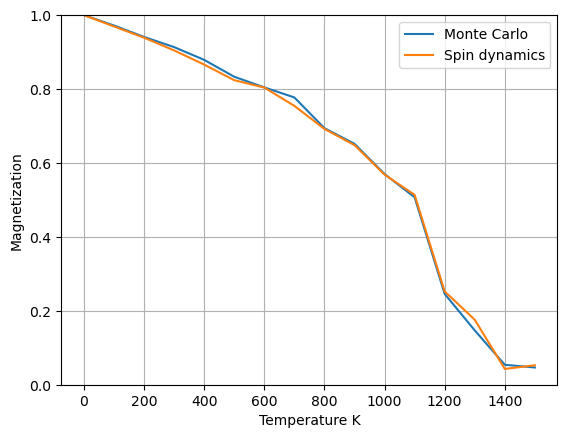

In [6]:
plt.xlabel("Temperature K")
plt.ylabel("Magnetization")
plt.ylim([0, 1])
plt.grid()
plt.plot(T_lst, m_mc_lst, label="Monte Carlo")
plt.plot(T_lst, m_sd_lst, label="Spin dynamics")
plt.legend();

Here, as we chose the Heisenberg parameter randomly, the Curie temperature is somewhat higher than the experimental value of 1,043 K. In addition, since the system is relatively small, the total magnetization after the transition does not completely vanish. The residual magnetization values above the Curie temperature can therefore vary each time you run the simulation. The unit if the magnetization is given by the Heisenberg parameter. You can see that Monte Carlo and spin dynamics are (not so surprisingly) comparable.

## Reproduce literature values

Here I do a small comparison between mamonca and the results given [in this paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.103.024421). The paper is about Fe-Mn, but for the sake of simplicity, I reproduce the results only for Fe.

The Hamiltonian is given by:

$$\mathcal H = -\frac{1}{2}\sum_{ij}J_{ij}m_im_j + \sum_i (A m_i^2 + B m_i^4)$$

where $m_i$ is the magnetic moment of the atom $i$, $J_{ij}$ are the Heisenberg parameters and $A$ and $B$ are the longitudinal Landau parameters.

As the simulation takes more time, only the results for Monte Carlo are shown. You can turn on the spin dynamics in the same way as above.

In [7]:
# Create bcc structure (which is the ground state of iron)
bcc = StructureFactory().bulk("Fe", cubic=True).repeat(20)

neigh = bcc.get_neighbors(num_neighbors=80)

In [8]:
J_lst = np.array([3.39, 2.26, 0.83, 0.42, 0.44]) / 1000
A = -0.259
B = 0.0276

In [9]:
mc = MC(len(bcc))
for nn, JJ in zip(neigh.get_shell_matrix()[:len(J_lst)], J_lst):
    mc.set_heisenberg_coeff(nn * JJ)
mc.set_landau_coeff(A, 2)
mc.set_landau_coeff(B, 4)
m_lst = []
T_lst = np.arange(0, 1600, 100)

for T in tqdm(T_lst):
    mc.run(temperature=T, number_of_iterations=20000)
    m_lst.append(mc.get_magnetization()[-100:].mean())

  0%|          | 0/16 [00:00<?, ?it/s]

In [10]:
with open("../references/magnetization.dat", "r") as f:
    data = np.array(f.read().split(), dtype=float).reshape(-1, 2)

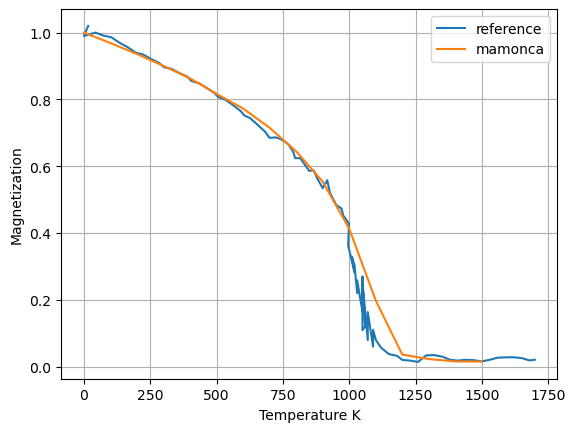

In [11]:
plt.plot(*data.T, label="reference")
plt.ylabel("Magnetization")
plt.xlabel("Temperature K")
plt.grid()
plt.plot(T_lst, m_lst / m_lst[0], label="mamonca")
plt.legend();

We can see that there's a small difference between mamonca and the reference values. The reason is probably because the values in the paper are truncated at 0.01 meV for all J values and , which can have quite some effects on the final results.

## Thermodynamic integration

Let's now take a look at the energy difference of iron in the two most prominent phases: Face-Centered-Cubic (fcc) and Body-Centered-Cubic (bcc). The energy difference can be calculated using [Thermodynamic Integration](https://en.wikipedia.org/wiki/Thermodynamic_integration), where we vary the unitless $\lambda$ parameter (cf. [Wikipedia](https://en.wikipedia.org/wiki/Thermodynamic_integration#Derivation)) and integrate over the measured potential energies.

In [12]:
fcc = StructureFactory().bulk("Fe", crystalstructure="fcc", a=3.5, cubic=True).repeat(10)

# Let's make a fictitious bcc structure by applying a strain of -10% along z.
# This obviously does not create a real bcc structure, but it's good enough for our purpose to find the right neighbors
bcc = fcc.apply_strain([0, 0, -0.1], return_box=True)

neigh_fcc = fcc.get_neighbors()
neigh_bcc = bcc.get_neighbors(num_neighbors=8)

In [13]:
J_fcc = -0.1
J_bcc = 0.5

In [14]:
mc = MC(len(fcc))
mc.set_heisenberg_coeff(J_bcc * neigh_bcc.get_shell_matrix()[0])
mc.set_heisenberg_coeff(J_fcc * neigh_fcc.get_shell_matrix()[0], index=1)

In [15]:
ti_lambda = np.linspace(0, 1, 11)
temperature = 300

In [16]:
E_lst = []
relaxation_steps = 5000
measurement_steps = 5000
for ll in ti_lambda:
    mc.set_lambda(ll)
    mc.run(temperature=temperature, number_of_iterations=relaxation_steps)
    mc.run(temperature=temperature, number_of_iterations=measurement_steps)
    E_lst.append(
        [mc.get_mean_energy(index=ii) for ii in [0, 1]]
    )

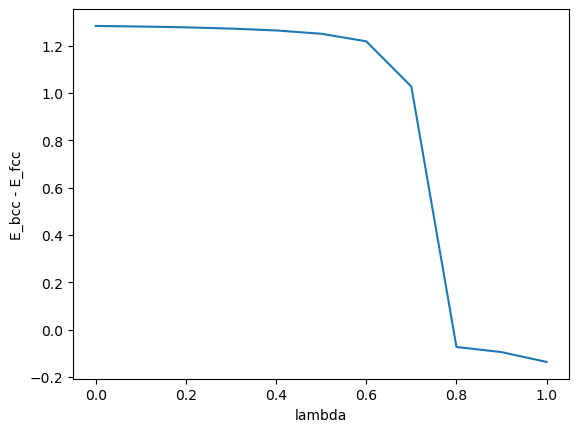

In [17]:
E_diff = np.diff(E_lst, axis=-1).flatten() / len(fcc)
plt.xlabel("lambda")
plt.ylabel("E_bcc - E_fcc")
plt.plot(ti_lambda, E_diff);

In [18]:
print("The free energy difference between bcc and fcc at 300 K is", E_diff.sum() * np.diff(ti_lambda).mean(), "eV")

The free energy difference between bcc and fcc at 300 K is 0.9565999950953374 eV


## Metadynamics

[Metadynamics](https://en.wikipedia.org/wiki/Metadynamics) is a simulation method which allows for the free energy distribution along a collective variable defined by the user. In mamonca, you can use the total magnetization as the collective variable, meaning you can obtain the free energy distribution along the total magnetization. For this, you only need to call `set_metadynamics` before `run`, where you must also specify the maximum magnetization value. In order to obtain a reliable result, you should also test the robustness by varying `energy_increment` and `length_scale` (cf. [Wikipedia](https://en.wikipedia.org/wiki/Metadynamics#Algorithm), where `energy_increment` is called $\omega$ and `length_scale` is called $\sigma$)

Here, we run 10 calculations and get the average to ensure that the results are representative.

In [19]:
# Create bcc structure (which is the ground state of iron)
bcc = StructureFactory().bulk("Fe", cubic=True).repeat(10)
neigh = bcc.get_neighbors(num_neighbors=8)

In [20]:
J = 0.05 * neigh.get_shell_matrix()[0]

F_list = []
for _ in range(10):
    mc = MC(len(bcc))
    mc.set_heisenberg_coeff(J)
    temperature = 1000
    mc.set_metadynamics(max_range=1)
    mc.run(temperature=temperature, number_of_iterations=100000)
    meta = mc.get_metadynamics_free_energy()
    F_list.append(meta["free_energy"])

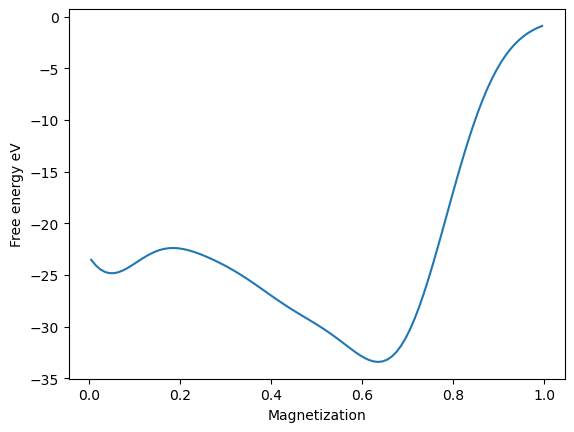

In [22]:
plt.xlabel("Magnetization")
plt.ylabel("Free energy eV")
plt.plot(meta["magnetization"], np.mean(F_list, axis=0));

The free energy minimum shows the most stable state. In this case it is around 0.6. Metadynamics, however, often requires a meticulous sampling, meaning with the standard energy increment of 0.001, you might overshoot and miss the global minimum. For a real measurement, it is recommended to make it as small as possible, meaning you should estimate the amount of time needed to run your calculation with Metadynamics with a small energy increment value and see what would be an acceptable total computation time.